DU Jean-Louis / 28706249

# <font color = "bluesteel"> Projet 029 </font>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix

##  <font color = "limegreen"> Exercice 1 </font>

In [2]:
def GenerateRectangleMesh(Lx, Ly, Nx, Ny):
    """ Génère un maillage rectangulaire
        Lx : longueur horizontale 
        Ly : Longueur verticale 
        Nx : Nombre de subdivisions horizontales 
        Ny : Nombre de subdivisions verticales """

    # On crée les tableaux de la bonne taille
    nbr_vtx = (Nx+1)*(Ny+1) 
    vtx = np.zeros((nbr_vtx,2),dtype=float)
    nbr_elt = 2*Nx*Ny
    elt = np.zeros((nbr_elt,3),dtype=int)

    p = Nx+1
    q = Ny+1
    step_x = Lx/Nx
    step_y = Ly/Ny

    # Compteurs 
    k_vtx = 0
    k_elt = 0
    
    # Remplir les tableaux
    for i in range(q):
        for j in range(p):
            # Pour rajouter les éléments il nous faut une itération de moins que pour les éléments
            if i < Ny and j < Nx:      
                elt[k_elt] = np.array([j+i*p ,j+1+i*p, j+1+(i+1)*p])    
                k_elt += 1
                elt[k_elt] = np.array([j+i*p ,j+1+(i+1)*p, j+(i+1)*p]) 
                k_elt += 1

            vtx[k_vtx] = np.array([step_x*j, step_y*i])
            k_vtx += 1
            
    return vtx, elt

In [3]:
def GeometricRefinement(vtx, elt, r):
    """ Raffine le maillage autour de l'origine 
        Il le fait r (un nombre entier) fois """

    # Condition d'arrêt de la récursion
    if r == 0:
        return vtx, elt

    else :
        nbr_vtx = len(vtx)
        nbr_elt = len(elt)
        # On fait une copie pour ne pas modifier le maillage initial
        eltcopy = np.copy(elt)
        
        # Les points importants sont les quatres dans le premier coin
        a, b, c = elt[0]
        d = elt[1][2]
        
        # vtx[a] est le point (0,0) on peut l'enlever si l'on veut
        new_vtx = np.array([vtx[d]/2, vtx[c]/2, vtx[b]/2])
        vtx_refine = np.concatenate((vtx, new_vtx))

        # On a les nouveaux points
        # On peut accéder aux indices avec nbr_vtx, nbr_vtx+1, nbr_vtx+2
        new0, new1, new2 = nbr_vtx, nbr_vtx+1, nbr_vtx+2

        # On garde en tant que triangle 0 et 1 le coin inférieur gauche
        eltcopy[0] = np.array([0, new2, new1])
        eltcopy[1] = np.array([0, new1, new0])

        # Les 4 autres nouveaux triangles sont ajoutés à la fin du tableau elt
        new_elt = np.array([[new1, d, new0],[new1, c, d],[new1, b, c],[new1, new2, b]])
        elt_refine = np.concatenate((eltcopy, new_elt))

    return GeometricRefinement(vtx_refine, elt_refine, r-1)

In [4]:
def Boundary(elt):
    """ Renvoie les arrêtes qui constitue le bord du maillage """
    
    # b permet de voir les arrêtes visités
    b = set()
    
    # Boucle sur les éléments
    for c in range(len(elt)):
        kc = elt[c]
        # Boucle sur les arrêtes
        for j in range(3):
            # fj est un tuple qui représente une arrête
            fj = (kc[j%3], kc[(j+1)%3])
            fj = tuple(np.sort(fj))
            if fj not in b:
                b.add(fj)
            else :
                b.remove(fj)
                
    return np.array(list(b))

In [5]:
def PlotMesh(vtx, elt, belt=set(),title="Maillage"):
    """ Affiche graphiquement le maillage considéré étant donné les tableaux vtx, elt, belt correspondant """
    
    x = vtx[:,0]
    y = vtx[:,1]
    
    plt.triplot(x, y, elt, "g-")
    
    for i in range(len(belt)):
        xx = [vtx[(belt[i])[1]][0],vtx[(belt[i])[0]][0]]
        yy = [vtx[(belt[i])[1]][1],vtx[(belt[i])[0]][1]]
        plt.plot(xx,yy,"b--")
        
    plt.plot(vtx[:,0], vtx[:,1], ".", color = "red")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()

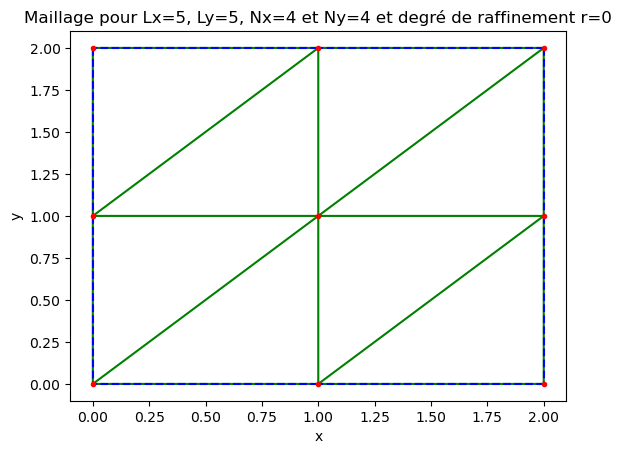

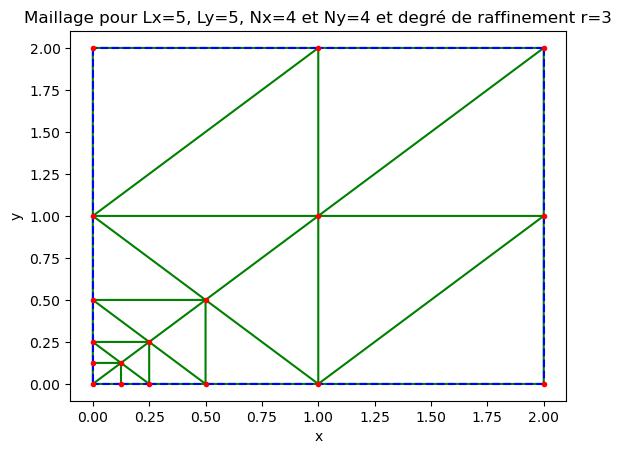

In [6]:
# Test des fonctions

# Donnée du maillage
Lx_test, Ly_test, Nx_test, Ny_test = 2, 2, 2, 2

# Tableaux générés
vtx_test, elt_test = GenerateRectangleMesh(Lx_test,Ly_test,Nx_test,Ny_test)
belt_test = Boundary(elt_test)
vtx_r, elt_r = GeometricRefinement(vtx_test, elt_test, 3)

# Plot
PlotMesh(vtx_test, elt_test, Boundary(elt_test), "Maillage pour Lx=5, Ly=5, Nx=4 et Ny=4 et degré de raffinement r=0")
PlotMesh(vtx_r, elt_r, Boundary(elt_r), "Maillage pour Lx=5, Ly=5, Nx=4 et Ny=4 et degré de raffinement r=3")

##  <font color = "limegreen"> Exercice 2 </font>

On obtient la formulation variationnelle suivante :

$$
\text{Trouver } u \in H_0^1(\Omega) \text{ tel que} 
$$

$$
\int_{\Omega} \mu \nabla u \cdot \nabla v + uv \, dx = \int_{\Omega} fv \, dx
$$

On va résoudre ce problème dans l'espace d'approximation $V_h$
Dans cet espace le problème peut s'écrire sous la forme d'un système linéaire
$$ AX = B $$
$$ A \in \mathbb{R}^{Nv \times Nv}, \ \ \ X, B \in \mathbb{R}^{Nv}$$

In [7]:
def mu(v, Lx, Ly):
    """ v : Array de taille (2,) 
        Donne l'évaluation de mu au point v selon Lx et Ly les longueurs du maillage """
    x, y = v
    return 2+np.sin(2*np.pi*x/Lx)*np.sin(4*np.pi*y/Ly)

In [8]:
# Routine pour le terme de Masse

mat_masse_elem_2D = np.array([[2,1,1],[1,2,1],[1,1,2]])
mat_masse_elem_1D = np.array([[2,1],[1,2]])

def Mloc(vtx, e):
    """ vtx : Tableau avec les coordonnées de chaque noeuds / sommets
        e : Tableau de 3 entiers qui désigne les triangles
        ou e : Tableau de 2 entiers qui désigne une arrête
        Renvoie la matrice de Masse locale """
    
    if len(e)==3:
        s0 = vtx[e[0]]
        s1 = vtx[e[1]]
        s2 = vtx[e[2]]
        aire = np.abs(np.cross(s1-s0, s2-s0))/2
        return mat_masse_elem_2D*aire/12

    elif len(e)==2:
        s0 = vtx[e[0]]
        s1 = vtx[e[1]]
        long = np.linalg.norm(s0-s1)
        return mat_masse_elem_1D*long/6

def Mass(vtx, elt):
    """ Assemble la matrice de Masse globale """
    
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)
    d = np.shape(elt)[1]
    I = np.zeros(d*d*nbr_elt)
    J = np.zeros(d*d*nbr_elt)
    V = np.zeros(d*d*nbr_elt)
    
    for l in range(nbr_elt):
        elem = elt[l]
        M_elem = Mloc(vtx, elem)
        for j in range(d):
            for k in range(d):
                i = d*d*l+d*j+k
                I[i] = elem[j]
                J[i] = elem[k]
                V[i] = M_elem[j,k]
                
    return coo_matrix((V, (I, J)), shape=(nbr_vtx, nbr_vtx)).toarray()

# Test pour vérifier que la Mass fonctionne
M_test = Mass(vtx_test, elt_test)
MB_test = Mass(vtx_test, belt_test)
vec1 = np.ones(len(vtx_test))
print("Aire du domaine : ",vec1@M_test@vec1)
print("Périmètre du domaine : ",vec1@MB_test@vec1)

Aire du domaine :  4.0
Périmètre du domaine :  8.0


In [9]:
# Routine pour assembler le terme de rididité légèrement modifié

def Kloc(vtx, e, Lx, Ly):
    """ vtx : Tableau avec les coordonnées de chaque noeuds / sommets
        e : Tableau de 3 entiers qui désigne les triangles
        ou e : Tableau de 2 entiers qui désigne une arrête
        Renvoie à la fois la matrice de rigidité modifié du problème (pour la résolution du problème) 
        et la matrice de rigidité locale classique (pour le calcul de la norme H1)
        """
    
    d = len(e)
    if d==3:

        # On commence par définir les quantités dont on va se servir
        s0 = np.hstack((vtx[e[0]],np.array([0])))
        s1 = np.hstack((vtx[e[1]],np.array([0])))
        s2 = np.hstack((vtx[e[2]],np.array([0])))
        s = [s0,s1,s2]
        e3 = np.array([0,0,1])
        n0 = np.cross(s1-s2,e3)
        n1 = np.cross(s2-s0,e3)
        n2 = np.cross(s0-s1,e3)
        n = [n0,n1,n2]

        # On remplit la matrice locale
        mat = np.zeros((d,d))
        for j in range(d):
            for k in range(d):
                num = n[j].T@n[k]
                denom = (s[j]-s[(j+1)%3]).T@n[j]*(s[k]-s[(k+1)%3]).T@n[k]
                mat[j][k] = num/denom

        # On calcule l'aire et la somme des mus
        aire = np.abs(np.cross(s1-s0, s2-s0)[2])/2
        sum_mu = mu(s0[:2], Lx, Ly) + mu(s1[:2], Lx, Ly) + mu(s2[:2], Lx, Ly)

        # On renvoit la rigidité locale modifié du problème, ainsi que la rigidité locale classique 
        return aire*mat*sum_mu/3, aire*mat

    elif d==2:

        s0 = vtx[e[0]]
        s1 = vtx[e[1]]
        s = [s0,s1]
        n0 = s0-s1
        n1 = s1-s0
        n = [n0,n1]
        mat = np.zeros((d,d))
        
        for j in range(d):
            for k in range(d):
                num = n[j].T@n[k]
                denom = (s[j]-s[(j+1)%2]).T@n[j]*(s[k]-s[(k+1)%2]).T@n[k]
                mat[j][k] = num/denom
                
        long = np.linalg.norm(s0-s1)
        sum_mu = mu(s0, Lx, Ly) + mu(s1, Lx, Ly)

        # Même chose
        return long*mat*sum_mu/2, long*mat

def Rig(vtx, elt, Lx, Ly):
    """ Assemble les matrices de rigidité (celle du problème et celle classique) """
    nbr_vtx = len(vtx)
    nbr_elt = len(elt)
    d = np.shape(elt)[1]
    
    I = np.zeros(d*d*nbr_elt)
    J = np.zeros(d*d*nbr_elt)
    V1 = np.zeros(d*d*nbr_elt)
    V2 = np.zeros(d*d*nbr_elt)
    
    for l in range(nbr_elt):
        elem = elt[l]
        K_elem1, K_elem2 = Kloc(vtx, elem, Lx, Ly)
        for j in range(d):
            for k in range(d):
                i = d*d*l+d*j+k
                I[i] = elem[j]
                J[i] = elem[k]
                V1[i] = K_elem1[j,k]
                V2[i] = K_elem2[j,k]
                
    return coo_matrix((V1, (I, J)), shape=(nbr_vtx, nbr_vtx)).toarray(), coo_matrix((V2, (I, J)), shape=(nbr_vtx, nbr_vtx)).toarray()

# Test pour vérifier la validité de K
K_test = Rig(vtx_test, elt_test, Lx_test, Ly_test)[1]
vec_e1 = [vtx_test[i][0] for i in range(len(vec1))]
print(vec1@K_test@vec1)
print(vec_e1@K_test@vec_e1)

0.0
4.0


In [10]:
def create_D(vtx, belt):
    """ Créer la matrice avec des 1 pour les noeuds du bord et 0 sinon """
    
    vec = np.zeros(len(vtx))
    for i in range(len(belt)):
        vec[belt[i][0]] = 1
        vec[belt[i][1]] = 1
        
    return np.diag(vec)

In [11]:
def MatA(vtx, elt, belt, Lx, Ly):
    """ Crée la matrice A du système linéaire
        On fait la pseudo élimination """
    
    M = Mass(vtx, elt)
    K = Rig(vtx, elt, Lx, Ly)[0]
    D = create_D(vtx, belt)
    I = np.eye(len(vtx))
    
    return (I-D)@(M+K)+D

##  <font color = "limegreen"> Exercice 3 </font>

In [12]:
alpha_test = 1

def uex(v, alpha, Lx, Ly):
    """ v dans R2 
    Dépend de alpha, Lx et Ly """
    x, y = v
    return (x*y)**alpha*(x-Lx)*(y-Ly)

def dx_uex(v, alpha, Lx, Ly):
    """ Dérivée selon x de uex """
    x, y = v
    p1 = y**alpha*(y-Ly)
    p2 = (alpha+1)*x**alpha - alpha*Lx*x**(alpha-1)
    return p1*p2

def dy_uex(v, alpha, Lx, Ly):
    """ Dérivée selon y de uex """
    x, y = v
    p1 = x**alpha*(x-Lx)
    p2 = (alpha+1)*y**alpha - alpha*Ly*y**(alpha-1)
    return p1*p2

def dxx_uex(v, alpha, Lx, Ly):
    """ Dérivée seconde selon xx de uex """
    x, y = v
    p1 = y**alpha*(y-Ly)
    p2 = (alpha+1)*alpha*x**(alpha-1)
    if alpha != 1:
        p2 -= alpha*(alpha-1)*Lx*x**(alpha-2)
        return p1*p2
    return p1*p2

def dyy_uex(v, alpha, Lx, Ly):
    """ Dérivée seconde selon yy de uex """
    x, y = v
    p1 = x**alpha*(x-Lx)
    p2 = (alpha+1)*alpha*y**(alpha-1)
    if alpha != 1:
        p2 -= alpha*(alpha-1)*Ly*y**(alpha-2)
        return p1*p2
    return p1*p2

def dx_mu(v, Lx, Ly):
    """ Dérivée selon x de mu """
    x, y = v
    return np.sin(4*np.pi*y/Ly)*np.cos(2*np.pi*x/Lx)*2*np.pi/Lx

def dy_mu(v, Lx, Ly):
    """ Dérivée selon y de mu """
    x, y = v
    return np.sin(2*np.pi*x/Lx)*np.cos(4*np.pi*y/Ly)*4*np.pi/Ly

v0 = np.array([1,1])

In [13]:
def f(v, alpha, Lx, Ly):
    """ Donne le terme source du second membre, on le calcule en partant du fait que uex est solution du problème """
    
    mu_v = mu(v, Lx, Ly)
    dx_mu_v = dx_mu(v, Lx, Ly)
    dy_mu_v = dy_mu(v, Lx, Ly)

    uex_v = uex(v, alpha, Lx, Ly)
    dx_uex_v = dx_uex(v, alpha, Lx, Ly)
    dy_uex_v = dy_uex(v, alpha, Lx, Ly)
    dxx_uex_v = dxx_uex(v, alpha, Lx, Ly)
    dyy_uex_v = dyy_uex(v, alpha, Lx, Ly)
    
    return uex_v - dx_mu_v*dx_uex_v - mu_v*dxx_uex_v - dy_mu_v*dy_uex_v - mu_v*dyy_uex_v

print(f(v0, alpha_test, Lx_test, Ly_test))

9.0


In [14]:
def build_dico(elt):
    """ Renvoie un dictionnaire ayant pour clés un sommet et en valeur la liste des triangles contenant ce sommet """
    
    dico = {}
    for i in range(len(elt)):
        elem = elt[i]
        for j in range(3):
            if elem[j] not in dico:
                dico[elem[j]] = [i]
            else :
                dico[elem[j]].append(i)
    return dico

#dico_test = build_dico(elt_test)
#print(dico_test)
#PlotMesh(vtx_test, elt_test)

On a créé cette fonction pour évaluer phi en (s0+s1+s2)/3 en chaque triangle.
On remarque ensuite que cela vaut toujours 1/3, on peut le démontrer mathématiquement.
````
def phi(vtx, node, elem):
    """ Toujours 1/3 """
    # On trouve j
    index = elem.tolist().index(node)
    # Coordonnées des sommets du triangles 
    sj, sj1, sj2 = vtx[elem[index]], vtx[elem[(index+1)%3]], vtx[elem[(index+2)%3]]
    # Calcul nj
    nj = np.array([(-sj1+sj2)[1], (sj1-sj2)[0]])
    
    return (((sj+sj1+sj2)/3-sj1)@nj)/((sj-sj1)@nj)

phi(vtx_test, 1, np.array([0,1,5]))
````


In [15]:
def VecB(vtx ,elt, belt, alpha, Lx, Ly):
    """ Assemble le vecteur second membre du système linéaire """
   
    nbr_vtx = len(vtx)
    res = np.zeros(nbr_vtx)
    dico = build_dico(elt)
    # On parcourt tout les noeuds, tout les phi_i
    for i in range(nbr_vtx):
        # Pour chaque noeuds on parcourt les triangles correspondant au macro-élément
        for j in dico[i]:
            # sommets du triangle j
            elem = elt[j]
            s0, s1, s2 = vtx[elem[0]], vtx[elem[1]], vtx[elem[2]]
            aire = np.cross(s0-s1, s1-s2)/2
            # On remarque que phi vaut toujours 1/3 ici
            res[i] += f((s0+s1+s2)/3, alpha, Lx, Ly)*aire/3
            
    D = create_D(vtx, belt)
    I = np.eye(len(vtx))
    return (I-D)@res
            
B = VecB(vtx_test, elt_test, belt_test, alpha_test, Lx_test, Ly_test)
print(B)

[0.         0.         0.         0.         9.55109195 0.
 0.         0.         0.        ]


##  <font color = "limegreen"> Exercice 4 </font>

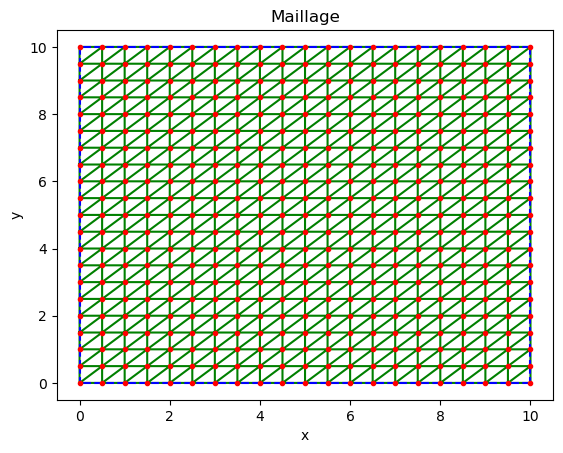

In [16]:
# Données

# Taille_maillage
Lx1, Ly1, Nx1, Ny1 = 10, 10, 20, 20

# Tableaux générés
vtx1, elt1 = GenerateRectangleMesh(Lx1,Ly1,Nx1,Ny1)
belt1 = Boundary(elt1)

# Plot
PlotMesh(vtx1, elt1, belt1)

alpha1 = 1

A1 = MatA(vtx1, elt1, belt1, Lx1, Ly1)
B1 = VecB(vtx1 ,elt1, belt1, alpha1, Lx1, Ly1)

sol1 = np.linalg.solve(A1,B1)

inter1 = [uex(vtx1[i], alpha1, Lx1, Ly1) for i in range(len(vtx1))]

erreur1 = np.abs(sol1-inter1)

M1 = Mass(vtx1, elt1)
K1 = Rig(vtx1, elt1, Lx1, Ly1)[0]
K1bis = Rig(vtx1, elt1, Lx1, Ly1)[0]

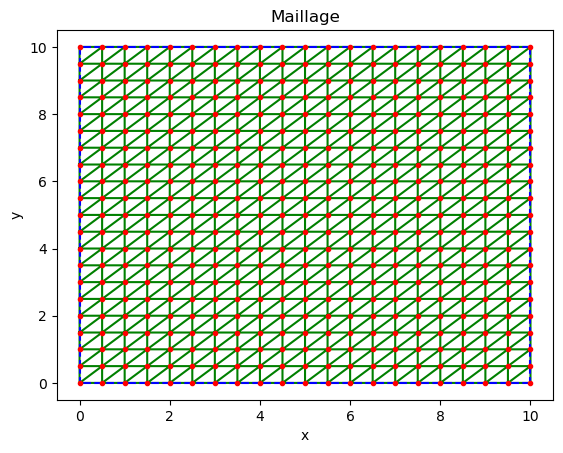

In [17]:
# Données

# Taille_maillage
Lx23, Ly23, Nx23, Ny23 = 10, 10, 20, 20

# Tableaux générés
vtx23, elt23 = GenerateRectangleMesh(Lx23,Ly23,Nx23,Ny23)
belt23 = Boundary(elt23)

# Plot
PlotMesh(vtx23, elt23, belt23)

alpha23 = 2/3

A23 = MatA(vtx23, elt23, belt23, Lx23, Ly23)
B23 = VecB(vtx23 ,elt23, belt23, alpha23, Lx23, Ly23)

sol23 = np.linalg.solve(A23,B23)

inter23 = [uex(vtx23[i], alpha23, Lx23, Ly23) for i in range(len(vtx23))]

erreur23 = np.abs(sol23-inter23)

M23 = Mass(vtx23, elt23)
K23 = Rig(vtx23, elt23, Lx23, Ly23)[1]

In [18]:
def PlotApproximation(vtx, elt, val=set(), title = "Plot"):
    """ Permet d'afficher les valeurs à chaque sommets """
    
    x = vtx[:,0]
    y = vtx[:,1]
    
    plt.figure()
    if len(val)==0:
        plt.triplot(x, y, elt, "go--")
    else :
        # shading = "gouraud"
        plt.tripcolor(x, y, elt, val, edgecolor = "blue", shading="flat", cmap = "Greens")
        plt.colorbar()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(title)
    plt.show()

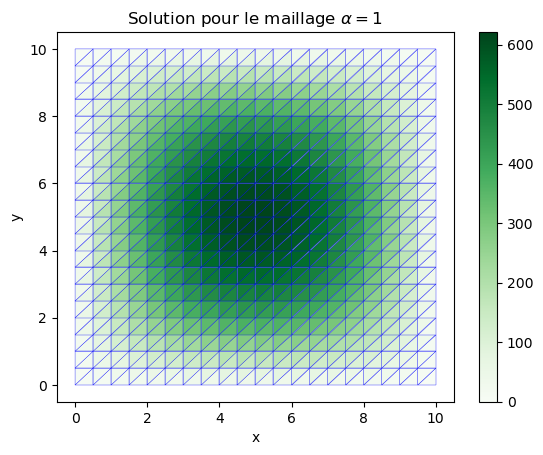

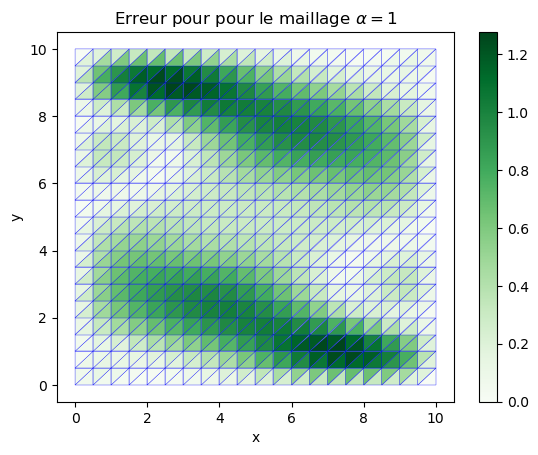

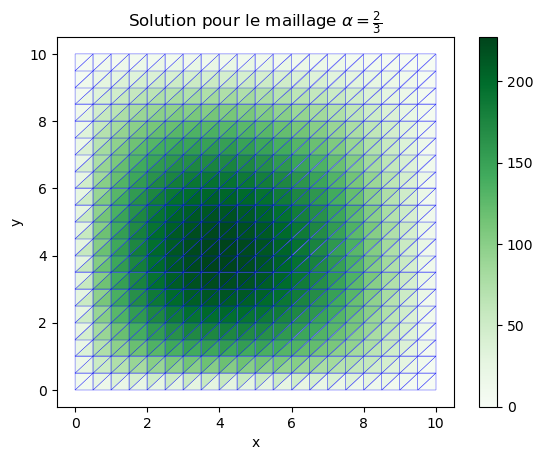

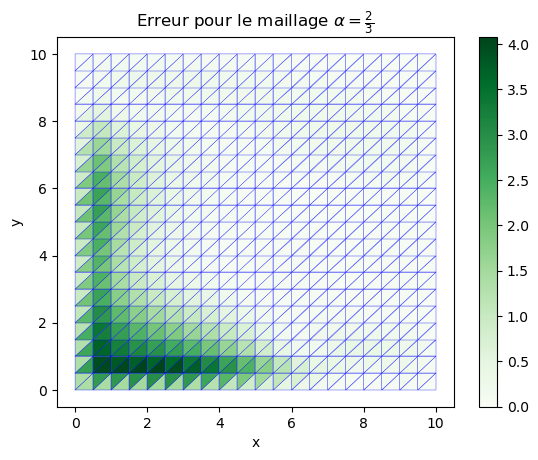

In [19]:
PlotApproximation(vtx1, elt1, sol1, r"Solution pour le maillage $\alpha = 1$")
PlotApproximation(vtx1, elt1, erreur1, r"Erreur pour pour le maillage $\alpha = 1$")

PlotApproximation(vtx23, elt23, sol23, r"Solution pour le maillage $\alpha = \frac{2}{3}$")
PlotApproximation(vtx23, elt23, erreur23, r"Erreur pour le maillage $\alpha = \frac{2}{3}$")

In [20]:
def probleme(Lx, Ly, alpha, N):
    """ Prend en entrée les tailles des maillages considérées et alpha 
        Renvoie l'erreur L2 et H1 """
    print(N)
    vtx, elt = GenerateRectangleMesh(Lx,Ly,N,N)
    belt = Boundary(elt)
    
    # Plot
    #PlotMesh(vtx, elt, belt)
    
    A = MatA(vtx, elt, belt, Lx, Ly)
    B = VecB(vtx ,elt, belt, alpha, Lx, Ly)
    
    sol = np.linalg.solve(A,B)
    
    inter = [uex(vtx[i], alpha, Lx, Ly) for i in range(len(vtx))]
    
    erreur = np.abs(sol-inter)
    
    M = Mass(vtx, elt)
    K = Rig(vtx, elt, Lx, Ly)[1]

    # Norme l2 carré de erreur et de interpolation
    q1 = erreur@M@erreur
    q2 = inter@M@inter

    # Semi norme H1 carré de erreur et de interpolation
    q3 = erreur@K@erreur
    q4 = inter@K@inter
    
    return np.array([np.sqrt(q1/q2), np.sqrt((q1+q3)/(q2+q4))])

10
20
30
40
50
10
20
30
40
50


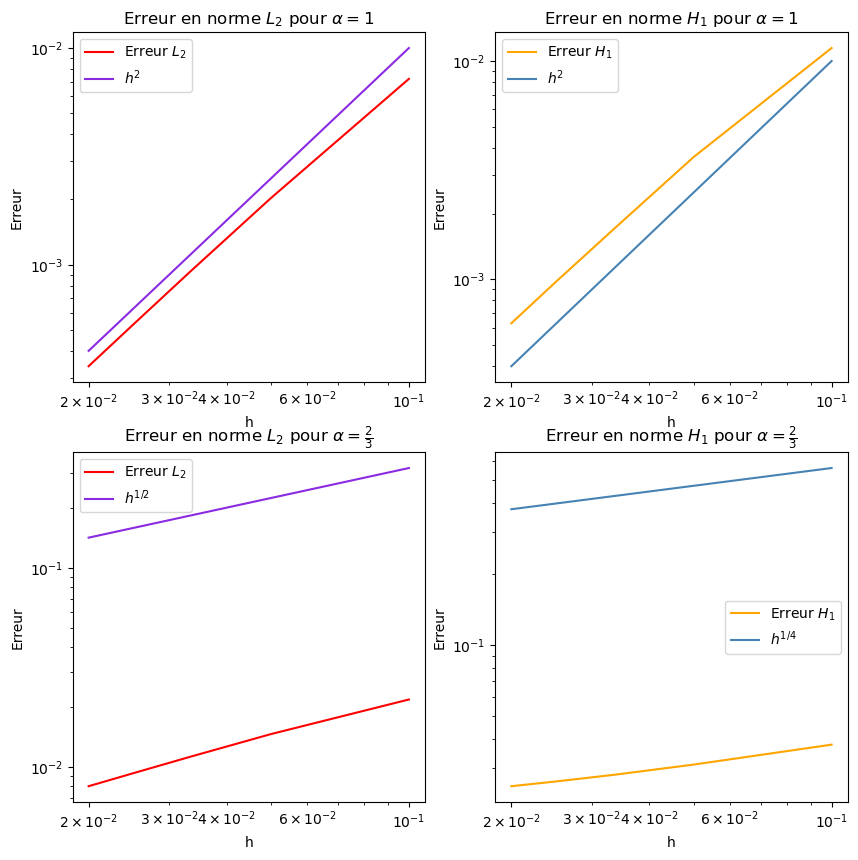

In [21]:
Lx, Ly = 4, 4
alpha1 = 1
alpha23 = 2/3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))

list_N = np.arange(10,51,10)
list_h = 1/list_N

res1 = np.array([probleme(Lx, Ly, alpha1, N) for N in list_N])
res23 = np.array([probleme(Lx, Ly, alpha23, N) for N in list_N])

ax1.loglog(list_h, res1[:,0], color="red", label = r"Erreur $L_2$")
ax1.loglog(list_h, list_h**2, color="blueviolet", label=r"$h^2$")
ax1.set_title(r"Erreur en norme $L_2$ pour $\alpha = 1$")
ax1.set_xlabel("h")
ax1.set_ylabel("Erreur")

ax2.loglog(list_h, res1[:,1], color="orange", label = r"Erreur $H_1$")
ax2.loglog(list_h, list_h**2, color="steelblue", label = r"$h^2$")
ax2.set_title(r"Erreur en norme $H_1$ pour $\alpha = 1$")
ax2.set_xlabel("h")
ax2.set_ylabel("Erreur")

ax3.loglog(list_h, res23[:,0], color="red", label = r"Erreur $L_2$")
ax3.loglog(list_h, list_h**(1/2), color="blueviolet", label = r"$h^{1/2}$")
ax3.set_title(r"Erreur en norme $L_2$ pour $\alpha = \frac{2}{3}$")
ax3.set_xlabel("h")
ax3.set_ylabel("Erreur")

ax4.loglog(list_h, res23[:,1], color="orange", label = r"Erreur $H_1$")
ax4.loglog(list_h, list_h**(1/4), color="steelblue", label = r"$h^{1/4}$")
ax4.set_title(r"Erreur en norme $H_1$ pour $\alpha = \frac{2}{3}$")
ax4.set_xlabel("h")
ax4.set_ylabel("Erreur")

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax1.set_xticks([1e-1, 2e-2])
ax2.set_xticks([1e-1, 2e-2])
ax3.set_xticks([1e-1, 2e-2])
ax4.set_xticks([1e-1, 2e-2])

plt.show()

Vous avez dans le dossier le graphe obtenu en pdf pour list_N = np.arange(10,101,10) si vous le souhaitez.